In [1]:
import torch
import triton
import math
from copy import deepcopy
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
from dyt import DYT
from rmsnorm import TritonRMSNorm
from apex.normalization import FusedRMSNorm
from transformer_engine.pytorch.module.rmsnorm import RMSNorm as TERMSNorm
from liger_kernel.transformers.dyt import LigerDyT

[WARNING  | root               ]: Supported flash-attn versions are >= 2.1.1, <= 2.6.3. Found flash-attn 2.7.4.post1.
/sharedata/mdy/miniforge/envs/cuda128/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dtype = torch.bfloat16
device = 'cuda'
bs, seq_len, dim = 1, 2048, 8192
beta = True
x1 = torch.randn(bs, seq_len, dim, device=device, dtype=dtype)
x1.requires_grad_(True)

x2 = deepcopy(x1)
dyt1 = DYT(dim, beta=beta).to(device).to(dtype)
dyt1.gemma.data.copy_(torch.randn(dim))
if beta:
    dyt1.beta.data.copy_(torch.randn(dim))
dyt2 = deepcopy(dyt1)


In [3]:
y1 = dyt1(x1, "torch")
y2 = dyt2(x2, "triton")
dy = torch.randn_like(y1)
y1.backward(dy)
y2.backward(dy)
print((y1-y2).abs().max(), (y1-y2).abs().mean())
print((x1.grad-x2.grad).abs().max(), (x1.grad-x2.grad).abs().mean())
print((dyt1.gemma.grad-dyt2.gemma.grad).abs().max(), (dyt1.gemma.grad-dyt2.gemma.grad).abs().mean())
if beta:
    print((dyt1.beta.grad-dyt2.beta.grad).abs().max(), (dyt1.beta.grad-dyt2.beta.grad).abs().mean())
print((dyt1.alpha.grad-dyt2.alpha.grad).abs() / dyt1.alpha.grad.abs())


Triton autotuning for function _dyt_bwd_kernel finished after 24.32s; best config selected: BLOCK_N: 1024, num_warps: 4, num_ctas: 1, num_stages: 1, maxnreg: None;
tensor(0.0312, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MaxBackward1>) tensor(0.0007, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MeanBackward0>)
tensor(0.0312, device='cuda:0', dtype=torch.bfloat16) tensor(0.0005, device='cuda:0', dtype=torch.bfloat16)
tensor(0.2500, device='cuda:0', dtype=torch.bfloat16) tensor(0.0349, device='cuda:0', dtype=torch.bfloat16)
tensor(0., device='cuda:0', dtype=torch.bfloat16) tensor(0., device='cuda:0', dtype=torch.bfloat16)
tensor([0.0069], device='cuda:0', dtype=torch.bfloat16)


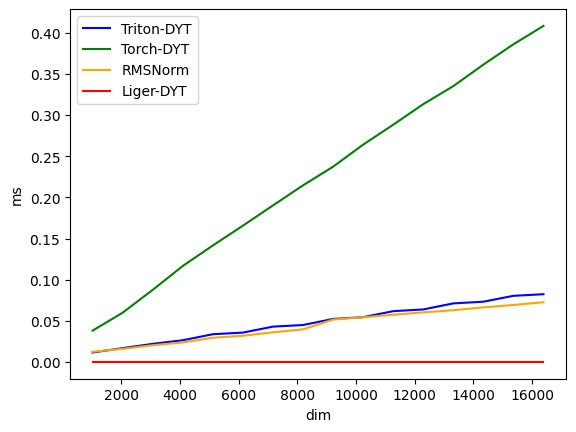

forward:
        dim  Triton-DYT  Torch-DYT   RMSNorm  Liger-DYT
0    1024.0    0.011484   0.038008  0.012312        0.0
1    2048.0    0.016751   0.059825  0.015905        0.0
2    3072.0    0.021949   0.087552  0.020293        0.0
3    4096.0    0.026335   0.116589  0.023672        0.0
4    5120.0    0.033668   0.141492  0.029418        0.0
5    6144.0    0.035613   0.165582  0.031831        0.0
6    7168.0    0.042901   0.190179  0.035965        0.0
7    8192.0    0.044846   0.214588  0.039585        0.0
8    9216.0    0.052222   0.237241  0.051461        0.0
9   10240.0    0.054397   0.264036  0.054295        0.0
10  11264.0    0.061670   0.288258  0.057325        0.0
11  12288.0    0.063772   0.313241  0.060236        0.0
12  13312.0    0.071145   0.335191  0.062842        0.0
13  14336.0    0.073178   0.361316  0.066260        0.0
14  15360.0    0.080337   0.386052  0.069228        0.0
15  16384.0    0.082294   0.408363  0.072553        0.0


In [2]:

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-DYT', "Torch-DYT", 'RMSNorm', "Liger-DYT"],  # possible values for `line_arg``
        line_names=[
            "Triton-DYT",
            "Torch-DYT",
            "RMSNorm",
            "Liger-DYT"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-'), ('red', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 1024, 'bs': 4, 'beta': False}
    ))
def benchmark(bs, seq_len, dim, beta, provider):
    device = torch.device('cuda')
    dtype = torch.bfloat16
    tensor = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'Triton-DYT':
        dyt = DYT(dim, beta=beta).to(device).to(dtype)
        ms = triton.testing.do_bench(lambda: dyt(tensor, 'triton'))
    if provider == 'Torch-DYT':
        dyt = DYT(dim, beta=beta).to(device).to(dtype)
        ms = triton.testing.do_bench(lambda: dyt(tensor, 'torch'))
    if provider == 'RMSNorm':
        norm = TritonRMSNorm(dim).to(device).to(dtype)
        # norm = FusedRMSNorm(dim).to(device).to(dtype)
        # norm = TERMSNorm(dim).to(device).to(dtype)
        ms = triton.testing.do_bench(lambda: norm(tensor))
    if provider == 'Liger-DYT':
        if not beta:
            return 0
        dyt = LigerDyT(dim).to(device).to(dtype)
        ms = triton.testing.do_bench(lambda: dyt(tensor))
    return ms
benchmark.run(show_plots=True, print_data=True)


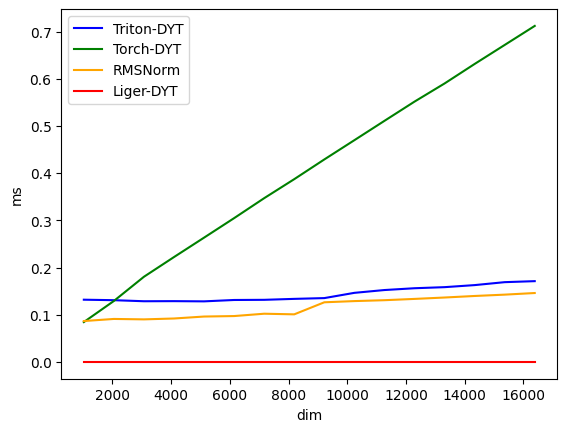

backward:
        dim  Triton-DYT  Torch-DYT   RMSNorm  Liger-DYT
0    1024.0    0.131824   0.084414  0.086592        0.0
1    2048.0    0.130795   0.129130  0.091051        0.0
2    3072.0    0.128559   0.180426  0.090142        0.0
3    4096.0    0.128761   0.222173  0.091997        0.0
4    5120.0    0.128306   0.263306  0.096140        0.0
5    6144.0    0.131214   0.304625  0.097171        0.0
6    7168.0    0.131562   0.346927  0.102125        0.0
7    8192.0    0.133575   0.387202  0.100790        0.0
8    9216.0    0.135215   0.428951  0.126335        0.0
9   10240.0    0.146344   0.469752  0.128877        0.0
10  11264.0    0.152290   0.510711  0.130760        0.0
11  12288.0    0.156107   0.551441  0.133493        0.0
12  13312.0    0.158396   0.589898  0.136451        0.0
13  14336.0    0.162739   0.631214  0.139706        0.0
14  15360.0    0.168979   0.671504  0.142544        0.0
15  16384.0    0.171123   0.711840  0.145964        0.0


In [2]:

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-DYT', "Torch-DYT", 'RMSNorm', "Liger-DYT"],  # possible values for `line_arg``
        line_names=[
            "Triton-DYT",
            "Torch-DYT",
            "RMSNorm",
            "Liger-DYT"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-'), ('red', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 1024, 'bs': 4, 'beta':False}
    ))
def benchmark(bs, seq_len, dim, beta, provider):
    device = torch.device('cuda')
    dtype = torch.bfloat16
    tensor = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    tensor.requires_grad_(True)
    dy = torch.rand_like(tensor)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'Triton-DYT':
        dyt = DYT(dim, beta=beta).to(device).to(dtype)
        y = dyt(tensor, 'triton')
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[tensor])
    if provider == 'Torch-DYT':
        dyt = DYT(dim, beta=beta).to(device).to(dtype)
        y = dyt(tensor, 'torch')
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[tensor])
    if provider == 'RMSNorm':
        norm = TritonRMSNorm(dim).to(device).to(dtype)
        # norm = FusedRMSNorm(dim).to(device).to(dtype)
        # norm = TERMSNorm(dim).to(device).to(dtype)
        y = norm(tensor)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[tensor])
    if provider == 'Liger-DYT':
        if not beta:
            return 0
        dyt = LigerDyT(dim).to(device).to(dtype)
        y = dyt(tensor)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[tensor])
    return ms
benchmark.run(show_plots=True, print_data=True)
